# Climate Indicies

Climate indicies are commonly used for analyzing climate variations from observations and models. xarrayutils contains some functions that make it easy to calculate climate indicies from any xarray dataset.

In [11]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The NINO indicies are defined on sea surface temperature (SST) data in different boxes in the equatorial Pacific. Lets use the NOAA ERSST v5 product to recreate them:

In [4]:
# load SST
sst = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc',
                      chunks={'time':1}, use_cftime=True)['sst']
# sort the latitude (this is a quirk of the dataset and not always needed)
sst = sst.sortby('lat').sel(lat=slice(-10, 10), time=slice('1960', None))

# usually we would want to use the actual area, but to keep it simple we just use ones here.
sst.coords['area'] = xr.ones_like(sst.isel(time=20).drop('time'))
sst

<xarray.DataArray 'sst' (time: 719, lat: 11, lon: 180)>
dask.array<getitem, shape=(719, 11, 180), dtype=float32, chunksize=(1, 11, 180)>
Coordinates:
  * lat      (lat) float32 -10.0 -8.0 -6.0 -4.0 -2.0 0.0 2.0 4.0 6.0 8.0 10.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1960-01-01 00:00:00 ... 2019-11-01 00:00:00
    area     (lat, lon) float32 dask.array<chunksize=(11, 180), meta=np.ndarray>
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

## NINO3.4 Index
The [NINO3.4 index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) is calculated from SST over a box from (5N-5S, 170W-120W).

In [5]:
from xarrayutils.climate_indicies import extract_climate_indicies

boxes = {'NINO3.4': {'lon': slice(190, 240), 'lat': slice(-5, 5)}}

# Since the data is downloaded from the opendap link on the fly, this can take a bit of time,
# depending on the internet connection speed
NINO = extract_climate_indicies(sst,
                                xdim='lon',
                                ydim='lat',
                                boxes=boxes,
                                print_map=True,
                                area_coord='area',
                                clim_period=slice('1960','1989')
                               )

[########################################] | 100% Completed |  0.3s
Calculating NINO3.4 index
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  2min 11.4s


> Note that the reference period over which the climatology is calculated can vary. You can specifiy the years over which to calculate the climatology with the `clim_period` kwarg.

> The `extract_climate_indicies` function has all NINO boxes hardcoded in, but only for the GFDL preferred longitude convention (290E - 70W) and thus the box has to be specified for this (0E - 360E) convention. Future work will automate this step.

Now we can plot the NINO3.4 index and compare it to the original plot from NCAR:

<!-- ![](https://climatedataguide.ucar.edu/sites/default/files/styles/node_lightbox_display/public/key_figures/climate_data_set/indices_oni_2_2_lg.png?itok=61jS7Jz7) -->

<img src="https://climatedataguide.ucar.edu/sites/default/files/styles/node_lightbox_display/public/key_figures/climate_data_set/indices_oni_2_2_lg.png?itok=61jS7Jz7" alt="Drawing" style="width: 400px;"/>

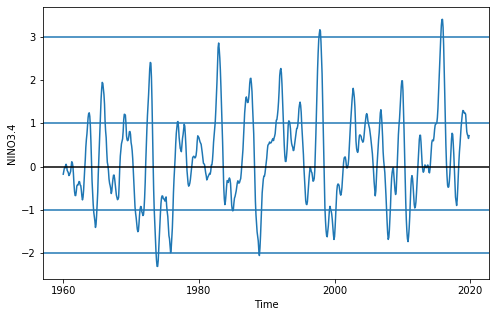

In [15]:
plt.figure(figsize=[8,5])
NINO['NINO3.4'].plot()
plt.axhline(0, color='k')
plt.axhline(1)
plt.axhline(3)

plt.axhline(-1)
plt.axhline(-2)

Looks pretty similar! Minor differences could result from the choice of dataset.